In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

**Problem 1: Homography Computation**

In [4]:

with open('homography.txt', 'r') as f:
    clean = f.read().replace(',', ' ')
pts = np.fromstring(clean, sep=' ').reshape(-1, 4)

P1 = pts[:, :2]
P2 = pts[:, 2:]

# Function to compute normalization matrix T
def normalize_points(P):
    x_mean = np.mean(P[:,0])
    y_mean = np.mean(P[:,1])
    P_shifted = P - np.array([x_mean, y_mean])
    d = np.mean(np.sqrt(np.sum(P_shifted**2, axis=1)))
    s = np.sqrt(2) / d
    T = np.array([
        [s, 0, -s*x_mean],
        [0, s, -s*y_mean],
        [0, 0, 1]
    ])
    # convert points to homogeneous
    P_h = np.hstack((P, np.ones((P.shape[0],1))))
    # apply transform
    P_norm = (T @ P_h.T).T
    return P_norm, T

# normalize both sets
P1_norm, T1 = normalize_points(P1)
P2_norm, T2 = normalize_points(P2)

# Build matrix A (30×9)
A = []
for i in range(P1_norm.shape[0]):
    x, y, _ = P1_norm[i]
    xp, yp, _ = P2_norm[i]

    A.append([-x, -y, -1, 0, 0, 0,  x*xp, y*xp, xp])
    A.append([ 0,  0,  0, -x, -y, -1, x*yp, y*yp, yp])

A = np.array(A)


# Solve Ah = 0 using eigenvector of ATA
ATA = A.T @ A
_, _, Vt = np.linalg.svd(ATA)
h = Vt[-1]         
H_tilde = h.reshape(3,3)

# Unnormalize
T2_inv = np.linalg.inv(T2)
H = T2_inv @ H_tilde @ T1

# scale 
H = H / H[2,2]

print("Final Homography H:\n", H)

Final Homography H:
 [[ 9.51549462e-01  1.18908748e+00 -5.25407219e+01]
 [-1.49517665e-01  6.65217265e-01  2.22045580e+02]
 [ 6.49006413e-04  8.21707227e-04  1.00000000e+00]]


**Discussion:** We used the normalized DLT algorithm to compute the homography by normalizing the points, building the linear system, and solving for H using SVD. The resulting matrix correctly maps points from image 1 into image 2.

**Part 2:**

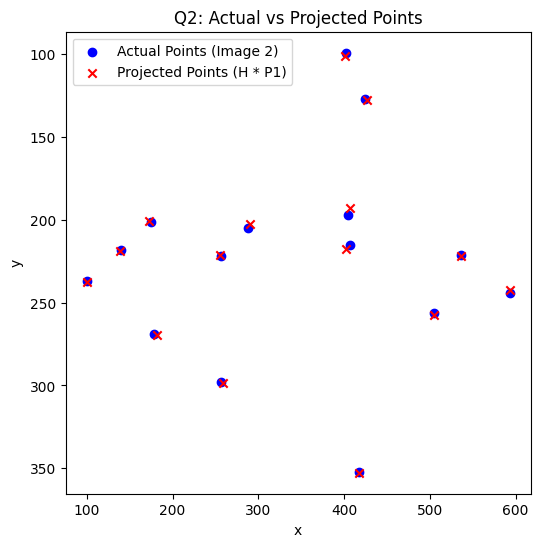

In [5]:


# Convert P1 points to homogeneous
P1_h = np.hstack([P1, np.ones((P1.shape[0], 1))])

# Apply homography
proj_h = (H @ P1_h.T).T

# Convert back to inhomogeneous
proj = proj_h[:, :2] / proj_h[:, 2][:, None]

# ---- Plot ----
plt.figure(figsize=(6,6))
plt.scatter(P2[:,0], P2[:,1], color='blue', label='Actual Points (Image 2)')
plt.scatter(proj[:,0], proj[:,1], color='red', marker='x', label='Projected Points (H * P1)')

plt.legend()
plt.title("Q2: Actual vs Projected Points")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().invert_yaxis()
plt.show()

**Discussion:** Applying the homography to the image 1 points produced projected points that closely align with the actual image 2 points. This shows the homography provides a good fit.

**Part 3:**

In [6]:
errors = (P2 - proj)**2
SSE = errors.sum()
print("SSE =", SSE)

SSE = 105.97387926939194


**Discussion:** We computed the SSE between the projected and actual points to measure the homography error. The SSE value reflects the small residual differences between the two sets of points.


**Problem 2:** Stereo/Disparity

In [ ]:


# Load images
left = imread('left.png').astype(np.float64)
right = imread('right.png').astype(np.float64)

# Convert grayscale to pseudo-RGB
if left.ndim == 2:
    left = np.stack([left, left, left], axis=2)
if right.ndim == 2:
    right = np.stack([right, right, right], axis=2)

H, W, C = left.shape
win = 11
r = win // 2
max_disp = 50

# Output disparity image
D = np.zeros((H, W))

# NCC function: color-based
def ncc(p1, p2):
    p1 = p1.reshape(-1, 3)
    p2 = p2.reshape(-1, 3)

    mu1 = p1.mean(axis=0)
    mu2 = p2.mean(axis=0)

    s1 = p1.std(axis=0, ddof=1)
    s2 = p2.std(axis=0, ddof=1)

    if np.any(s1 == 0) or np.any(s2 == 0):
        return -1  

    num = ((p1 - mu1) * (p2 - mu2)).sum()
    den = (len(p1) - 1) * (s1 * s2).sum()

    return num / den

# Main stereo loop
for y in range(r, H - r):
    for x in range(r, W - r):

        left_patch = left[y-r:y+r+1, x-r:x+r+1]
        best_score = -999
        best_disp = 0

        for d in range(max_disp + 1):
            xr = x - d
            if xr - r < 0:
                break  # can't search farther left

            right_patch = right[y-r:y+r+1, xr-r:xr+r+1]
            score = ncc(left_patch, right_patch)

            if score > best_score:
                best_score = score
                best_disp = d

        D[y, x] = best_disp

# Display disparity
plt.imshow(D, cmap='gray', vmin=0, vmax=50)
plt.title("Disparity Map (NCC, 11x11 Window)")
plt.axis('equal')
plt.show()

**Discussion:** We used an 11×11 NCC-based block matching method to compute disparity by searching leftward in the right image. The resulting disparity map reflects depth differences across the scene.
